In [1]:
%matplotlib nbagg

In [2]:
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"
import numpy
import fabio
import pyopencl
from pyopencl import array as cla
from matplotlib.pyplot import subplots

In [3]:
ctx = pyopencl.create_some_context(interactive=True)
queue = pyopencl.CommandQueue(ctx, properties=pyopencl.command_queue_properties.PROFILING_ENABLE)
ctx

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7fd9084e5020>
[1] <pyopencl.Platform 'NVIDIA CUDA' at 0x2f41c40>
[2] <pyopencl.Platform 'Intel(R) OpenCL' at 0x2e338d0>
Choice [0]:1
Choose device(s):
[0] <pyopencl.Device 'GeForce GTX TITAN' on 'NVIDIA CUDA' at 0x2f4d510>
[1] <pyopencl.Device 'Quadro M2000' on 'NVIDIA CUDA' at 0x2f41bb0>
Choice, comma-separated [0]:0
Set the environment variable PYOPENCL_CTX='1:0' to avoid being asked again.


<pyopencl.Context at 0x2f0b0e0 on <pyopencl.Device 'GeForce GTX TITAN' on 'NVIDIA CUDA' at 0x2f4d510>>

In [4]:
image = fabio.open("/users/kieffer/workspace-400/tmp/pyFAI/test/testimages/Pilatus6M.cbf").data
mask = (image<0).astype("int8")

<IPython.core.display.Javascript object>


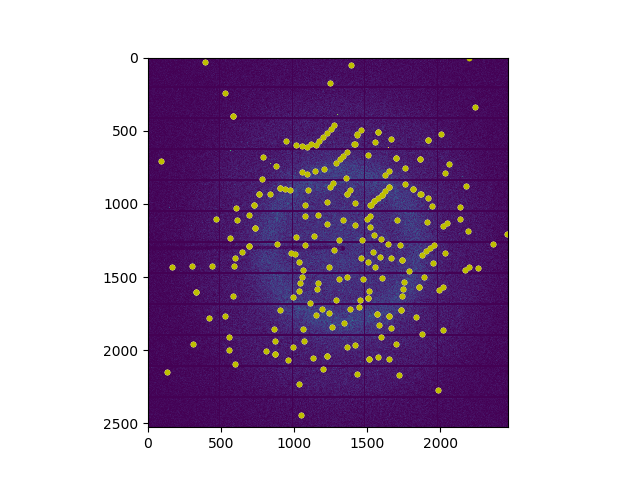

In [5]:
fig, ax = subplots()
ax.imshow(image.clip(0,100))

In [6]:
%load_ext pyopencl.ipython_ext

In [10]:
%%cl_kernel

//read withou caching
float inline read_simple(global int *img, 
                     int height,
                     int width,
                     int row,
                     int col){
    //This kernel reads the value and returns it without active caching
    float value = NAN;
    
    // Read
    if ((col>=0) && (col<width) && (row>=0) && (row<height)){
        int read_pos = col + row*width;
        value = (float)img[read_pos];
        if (value<0){
            value = NAN;
        }
    }
    return value;
}


void inline read_and_store(global int *img, 
                     int height,
                     int width,
                     int row,
                     int col,
                     int half_wind_height,
                     int half_wind_width,
                     local float* storage){
    //This kernel reads the value and stores in the local storage
    int line_size, write_pos, idx_line;
    float value = NAN;
    
    // Read
    if ((col>=0) && (col<width) && (row>0) && (row<height)){
        int read_pos = col + row*width;
        value = (float)img[read_pos];
        if (value<0){
            value = NAN;
        }
    }
    // Save locally
    if ((col>=-half_wind_width) && (col<=width+half_wind_width) && (row>-half_wind_height) && (row<=height+half_wind_height)){
        line_size = get_local_size(0) + 2 * half_wind_width;
        idx_line = (half_wind_height+row)%(2*half_wind_height+1);
        write_pos = line_size*idx_line + half_wind_width + col - get_group_id(0)*get_local_size(0);
        storage[write_pos] = value;
    }
    //return value
}

//Store a complete line
void inline store_line(global int *img, 
                       int height,
                       int width,
                       int row,
                       int half_wind_height,
                       int half_wind_width,
                       local float* storage){
        read_and_store(img, height, width, 
                       row, get_global_id(0), 
                       half_wind_height, half_wind_width, storage);
        if (get_local_id(0)<half_wind_width){
            // read_and_store_left
            read_and_store(img, height, width, 
                           row, get_group_id(0)*get_local_size(0)-half_wind_width+get_local_id(0), 
                           half_wind_height, half_wind_width, storage);
            //read_and_store_right
            read_and_store(img, height, width, 
                           row, (get_group_id(0)+1)*get_local_size(0)+get_local_id(0), 
                           half_wind_height, half_wind_width, storage);            
        }
}

float read_back( int height,
                 int width,
                 int row,
                 int col,
                 int half_wind_height,
                 int half_wind_width,
                 local float* storage){
    float value=NAN;
    int write_pos, line_size, idx_line;
    if ((col>=-half_wind_width) && (col<=width+half_wind_width) && (row>-half_wind_height) && (row<=height+half_wind_height)){
        line_size = get_local_size(0) + 2 * half_wind_width;
        idx_line = (half_wind_height+row)%(2*half_wind_height+1);
        write_pos = line_size*idx_line + half_wind_width + col - get_group_id(0)*get_local_size(0);
        value = storage[write_pos];   
    }
    return value;
}

// workgroup size of kernel: 32 to 128, cache_read needs to be (wg+2*half_wind_width)*(2*half_wind_height+1)*sizeof(float)
kernel void spot_finder(global int *img, 
                               int height,
                               int width,
                               int half_wind_height,
                               int half_wind_width,
                               float threshold,
                               float radius,
                        global int *cnt_high, //output
                        global int *high,     //output
                               int high_size,
                        local  float *cache_read,
                        local  int *local_high,
                               int local_size){
    //decaration of variables
    int col, row, cnt, i, j, where;
    float value, sum, std, centroid_r, centroid_c, dist, mean;
    col = get_global_id(0);
    
    local int local_cnt_high[1];
    local_cnt_high[0] = 0;
    for (i=0; i<local_size; i+=get_local_size(0)){
        local_high[i+get_local_id(0)] = 0;
    }
        
    row=0;
    
    //pre-load data for the first line
    for (i=-half_wind_height; i<half_wind_height; i++){
        store_line(img, height, width, row+i, half_wind_height, half_wind_width, cache_read);
    }
    barrier(CLK_LOCAL_MEM_FENCE);
    //loop within a column
    for (row=0;row<height; row++){
        //read data
        store_line(img, height, width, row+half_wind_height, half_wind_height, half_wind_width, cache_read);
        barrier(CLK_LOCAL_MEM_FENCE);
        //calculate mean
        sum = 0.0f;
        centroid_r = 0.0f;
        centroid_c = 0.0f;
        cnt = 0;
        for (i=-half_wind_height; i<=half_wind_height; i++){
            for (j=-half_wind_width; j<=half_wind_width; j++){
                value = read_back(height, width, row+i, col+j, half_wind_height, half_wind_width, cache_read);
                if (isfinite(value)){
                    sum += value;
                    centroid_r += value*i; 
                    centroid_c += value*j;
                    cnt += 1;
                }
            }
        }
        if (cnt){
            mean = sum/cnt;
            dist = sum*radius;
            if ((fabs(centroid_r)<dist) && (fabs(centroid_c)<dist)){
                // calculate std
                sum = 0.0;
                for (i=-half_wind_height; i<=half_wind_height; i++){
                    for (j=-half_wind_width; j<=half_wind_width; j++){
                        value = read_back(height, width, row+i, col+j, half_wind_height, half_wind_width, cache_read);
                        if (isfinite(value)){
                            sum += pown(mean-value,2);
                        }
                    }
                }
                std = sqrt(sum/cnt);
                value = read_back(height, width, row, col, half_wind_height, half_wind_width, cache_read);
                if ((value-mean)>threshold*std){
                    where = atomic_inc(local_cnt_high);
                    if (where<local_size){
                        local_high[where] = col+width*row;
                    }
                } // if intense signal
            } // if properly centered
        } // if patch not empty            
        barrier(CLK_LOCAL_MEM_FENCE);
    } //for row      
    
    //Store the results in global memory
    barrier(CLK_LOCAL_MEM_FENCE);
    if (get_local_id(0) == 0) {
        cnt = local_cnt_high[0];
        if ((cnt>0) && (cnt<local_size)) {
            where = atomic_add(cnt_high, cnt);
            if (where+cnt>high_size){
                cnt = high_size-where; //store what we can
            }
            for (i=0; i<cnt; i++){
                high[where+i] = local_high[i];
            }
        }
    }//store results
} //kernel

// workgroup size of kernel: without cacheing read
kernel void simple_spot_finder(global int *img, 
                               int height,
                               int width,
                               int half_wind_height,
                               int half_wind_width,
                               float threshold,
                               float radius,
                        global int *cnt_high, //output
                        global int *high,     //output
                               int high_size,
                        local  int *local_high,
                               int local_size){
    //decaration of variables
    int col, row, cnt, i, j, where, tid, blocksize;
    float value, sum, std, centroid_r, centroid_c, dist, mean, M2, delta, delta2, target_value;
    col = get_global_id(0);
    row = get_global_id(1);
    
    //Initialization of output array in shared
    local int local_cnt_high[2];
    blocksize = get_local_size(0) * get_local_size(1);
    tid = get_local_id(0) + get_local_id(1) * get_local_size(0);
    if (tid < 2){
        local_cnt_high[tid] = 0;
    }
        
    for (i=0; i<local_size; i+=blocksize){
        if ((i+tid)<local_size)
            local_high[i+tid] = 0;
    }
    barrier(CLK_LOCAL_MEM_FENCE);        
    
    
    //Calculate mean + std + centroids
    mean = 0.0f;
    M2 = 0.0f;
    centroid_r = 0.0f;
    centroid_c = 0.0f;
    cnt = 0;
    
    for (i=-half_wind_height; i<=half_wind_height; i++){
        for (j=-half_wind_width; j<=half_wind_width; j++){
            value = read_simple(img, height, width, row+i, col+j);
            if (isfinite(value)){
                centroid_r += value*i; 
                centroid_c += value*j;
                cnt += 1;
                delta = value - mean;
                mean += delta / cnt;
                delta2 = value - mean;
                M2 += delta * delta2;
            }                
        }
    }
    if (cnt){
        dist = mean*radius*cnt;
        std = sqrt(M2 / cnt);
        target_value = read_simple(img, height, width, row, col);
        if (((target_value-mean)>threshold*std) && (fabs(centroid_r)<dist) && (fabs(centroid_c)<dist)){
                where = atomic_inc(local_cnt_high);
                if (where<local_size){
                    local_high[where] = col+width*row;
                }
        } // if intense signal properly centered
    } // if patch not empty            
    
    //Store the results in global memory
    barrier(CLK_LOCAL_MEM_FENCE);
    if (tid==0) {
        cnt = local_cnt_high[0];
        if ((cnt>0) && (cnt<local_size)) {
            where = atomic_add(cnt_high, cnt);
            if (where+cnt>high_size){
                cnt = high_size-where; //store what we can
            }
            local_cnt_high[0] = cnt;
            local_cnt_high[1] = where;
        }
    }
    barrier(CLK_LOCAL_MEM_FENCE);
    //copy the data from local to global memory
    for (i=0; i<local_cnt_high[0]; i+=blocksize){
        high[local_cnt_high[1]+i+tid] = local_high[i+tid];
    }//store results
} //kernel

In [11]:
def peak_count(img,
               window=3,
               threshold=3.0,
               radius=1.0,
               workgroup=32,
               array_size=10000):
    img_d = cla.to_device(queue, image)
    high_d = cla.zeros(queue, (array_size,), dtype=numpy.int32)
    high_cnt_d = cla.zeros(queue, (1,), dtype=numpy.int32)
    read_cache = pyopencl.LocalMemory(4*(workgroup+2*window)*(2*window+1))
    write_cache = pyopencl.LocalMemory(4096)
    height, width = img.shape
    size = (width+workgroup-1)&~(workgroup-1)
    ev = spot_finder(queue, (size,), (workgroup,),
                    img_d.data, 
                    numpy.int32(height),
                    numpy.int32(width),
                    numpy.int32(window),
                    numpy.int32(window),
                    numpy.float32( threshold),
                    numpy.float32( radius),
                    high_cnt_d.data,
                    high_d.data,
                    numpy.int32(array_size),
                    read_cache,
                    write_cache,
                    numpy.int32(1024))
    size = high_cnt_d.get()[0]     
    print("found %i peaks in %.3fms"%(size, (ev.profile.end-ev.profile.start)*1e-6))
    return high_d.get()[:size]
%time raw = peak_count(image, window=5, threshold=6)
x=raw%image.shape[-1]
y=raw//image.shape[-1]
ax.plot(x,y,".w")

found 234 peaks in 275.350ms
CPU times: user 233 ms, sys: 51.7 ms, total: 285 ms
Wall time: 282 ms


In [12]:
def simple_peak_count(img,
               window=3,
               threshold=3.0,
               radius=1.0,
               workgroup=32,
               array_size=10000):
    img_d = cla.to_device(queue, image)
    high_d = cla.zeros(queue, (array_size,), dtype=numpy.int32)
    high_cnt_d = cla.zeros(queue, (1,), dtype=numpy.int32)
    #read_cache = pyopencl.LocalMemory(4*(workgroup+2*window)*(2*window+1))
    write_cache = pyopencl.LocalMemory(4096)
    height, width = img.shape
    size_w = (width+workgroup-1)&~(workgroup-1)
    size_h = (height+workgroup-1)&~(workgroup-1)
    ev = simple_spot_finder(queue, (size_w,size_h), (workgroup, workgroup),
                    img_d.data, 
                    numpy.int32(height),
                    numpy.int32(width),
                    numpy.int32(window),
                    numpy.int32(window),
                    numpy.float32( threshold),
                    numpy.float32( radius),
                    high_cnt_d.data,
                    high_d.data,
                    numpy.int32(array_size),
                    #read_cache,
                    write_cache,
                    numpy.int32(1024))
    size = high_cnt_d.get()[0]     
    print("found %i peaks in %.3fms"%(size, (ev.profile.end-ev.profile.start)*1e-6))
    return high_d.get()[:size]
%time raw = simple_peak_count(image, window=5, threshold=6)
x=raw%image.shape[-1]
y=raw//image.shape[-1]
ax.plot(x,y,".y")

found 235 peaks in 21.018ms
CPU times: user 25.3 ms, sys: 4.65 ms, total: 29.9 ms
Wall time: 27.9 ms


In [43]:
# Work on scan
from math import log2
n = 32
ary = numpy.ones(n)
ary

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
ary1 = numpy.copy(ary)
ary2 = numpy.empty_like(ary)

for i in range(int(log2(n))):
    start = 1<<i
    print(i,start)
    for j in range(start):
        ary2[j] = ary1[j]
    for j in range(start, n):
        ary2[j] = ary1[j] + ary1[j-start]
    ary1, ary2 = ary2, ary1
print(ary1)

0 1
1 2
2 4
3 8
4 16
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]


In [34]:
ary-numpy.ones(n).cumsum()

array([  0.,   0.,   1.,   2.,   5.,   8.,  13.,  18.,  27.,  36.,  49.,
        62.,  81., 100., 125., 150.])

In [39]:
(32+6)*7*4*2*4

8512